In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import logging
import matplotlib.colors as colors
from matplotlib import cm
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2025-03-12 20:03:04.466505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 20:03:04.496047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 20:03:04.940845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Functions

In [2]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')

In [3]:
def coffee_data():
    """
        Creates a data coffee roasting data set.
        rosting duration [X]
        temperature range[Y]
    """

    rng = np.random.default_rng(2) 
    X = rng.random(400).reshape(-1,2)

    X[:,1] = X[:,1] * 4 + 11.5               #12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150       #350-500 F (175-260) is best

    Y = np.zeros(len(X))

    i = 0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d <= y):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    return (X, Y.reshape(-1,1))

In [4]:
def plt_roast(X, Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0], X[Y==1,1], s=70, marker='x', c='red', label='Good')
    ax.scatter(X[Y==0,0], X[Y==0,1], s=100, marker='o', facecolors='none', edgecolors=dlc["dldarkblue"], linewidth=1, label='Bad')
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"], linewidth=1)
    ax.axhline(y=12, color=dlc["dlpurple"], linewidth=1)
    ax.axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)", size=12)
    ax.set_ylabel("Duration \n(minutes)", size=12)
    ax.legend(loc='upper right')
    plt.show()

In [5]:
def sigmoid(z):
    """"
    Compute the sigmoid of z

    Parameters:
    z : array_like -> A scalar or numpy array of any size

    Returns:
    g : array_like -> sigmoid(z)
    """

    z = np.clip(z, -500, 500) # protect against overflow -> np.clip: limit the values in an array
    g = 1.0/(1.0 + np.exp(-z))

    return g

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
def plt_prob(ax, fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space = np.linspace(150, 285, 40)                     # return evenly spaced samples, calculated over the interval [start, stop].
    x1_space = np.linspace(11.5, 15.5, 40)                   # np.lispace(start, stop, num=50), num: number of samples to generate. Default is 50. Must be non-negative

    #get probability for x0, x1 ranges
    tmp_x0, tmp_x1 = np.meshgrid(x0_space, x1_space)         # np.meshgrid returns a tuple of coordinate matrices from coordinate vectors
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)

    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,                   # pcolormesh .- Create a pseudocolor plot with a non-regular rectangular grid
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

In [8]:
def plt_network(X,Y,netf):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    Y = Y.reshape(-1,)
    plt_prob(ax[0], netf)
    ax[0].scatter(X[Y==1,0],X[Y==1,1], s = 70, marker='x', c='red', label='Good Roast')
    ax[0].scatter(X[Y==0,0],X[Y==0,1], s = 100, marker='o', facecolors='none',
                  edgecolors=dlc["dldarkblue"], linewidth=1, label='Good Roast')
    ax[0].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"], linewidth=1)
    ax[0].axhline(y = 12, color=dlc["dlpurple"], linewidth=1)
    ax[0].axvline(x = 175, color=dlc["dlpurple"], linewidth=1)
    ax[0].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[0].set_ylabel("Duration \n(minutes)", size=12)
    ax[0].legend(loc='upper right')
    ax[0].set_title(f"network probability")

    ax[1].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"], linewidth=1)
    ax[1].axhline(y = 12, color=dlc["dlpurple"], linewidth=1)
    ax[1].axvline(x = 175, color=dlc["dlpurple"], linewidth=1)
    fwb = netf(X)
    yhat = (fwb > 0.5).astype(int)
    ax[1].scatter(X[yhat[:,0]==1,0],X[yhat[:,0]==1,1], s=70, marker='x', c='orange', label="Predicted Good Roast")
    ax[1].scatter(X[yhat[:,0]==0,0],X[yhat[:,0]==0,1], s=100, marker='o', facecolors='none',
                  edgecolors=dlc["dldarkblue"], linewidth=1, label="Predicted Bad Roast")
    ax[1].set_title(f"network decision")
    ax[1].set_xlabel("Temperature \n(Celsius)", size=12)
    ax[1].set_ylabel("Duration \n(minutes)", size=12)
    ax[1].legend(loc='upper right')

# DataSet

In [9]:
X, Y = coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


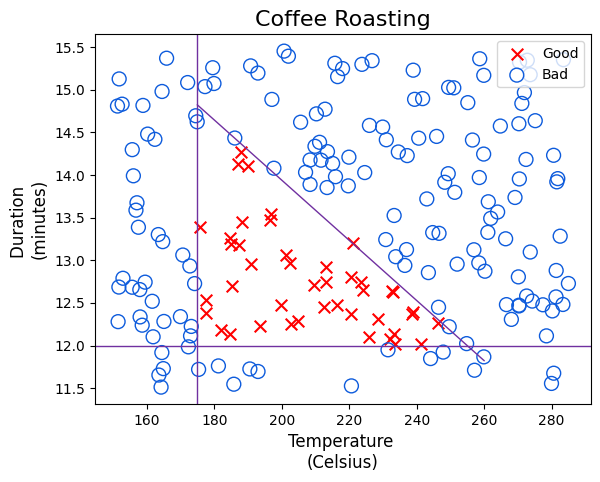

In [10]:
plt_roast(X, Y)

# Normalize Data

In [11]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X) #learns means, variance
Xn = norm_l(X)
print(f"Temperature Max, Min pre normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min pre normalization: 1.66, -1.69
Duration Max, Min pre normalization: 1.79, -1.70


2025-03-12 20:03:05.573251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-12 20:03:05.573533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# NumPy Model (Forward Prop in NumPy)

It is possible to build your own dense layer using NumPy.

In [12]:
g = sigmoid

In [13]:
def my_dense(a_in, W, b):
    """
    Computes dense layer

    Args:
    a_in (ndarray (n,)) : Data, 1 example
    W (ndarray (n,j))   : Weight matrix, n features per unit, j units
    b (ndarray (j,))    : bias vector, j units

    Returns:
    a_out (ndarray (j,))    : j units
    """

    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        w = W[:,j]
        z = np.dot(w, a_in) + b[j]
        a_out[j] = g(z)
    return(a_out)

The following builds a two-layer neural network

In [14]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x, W1, b1)
    a2 = my_dense(a1, W2, b2)
    return a2

We are going to take advantage of the weights and biases trained previously.

In [15]:
W1_tmp = np.array( [[-8.93, 0.29, 12.9], [-0.1, -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28, 0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.42] )

# Predictions

This is a routine similar to TensorFlow's `model.predict()`

In [16]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
    return p

Trying this routine on two examples:

In [17]:
X_tst = np.array([
    [200, 13.9], # positive example
    [200, 17]])  # negative example
X_tstn = norm_l(X_tst)
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)


/tmp/ipykernel_124135/2071595767.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)


To convert the probabilities to a decision, we apply a threshold:

In [18]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


/tmp/ipykernel_124135/2071595767.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2)
/tmp/ipykernel_124135/1666557548.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


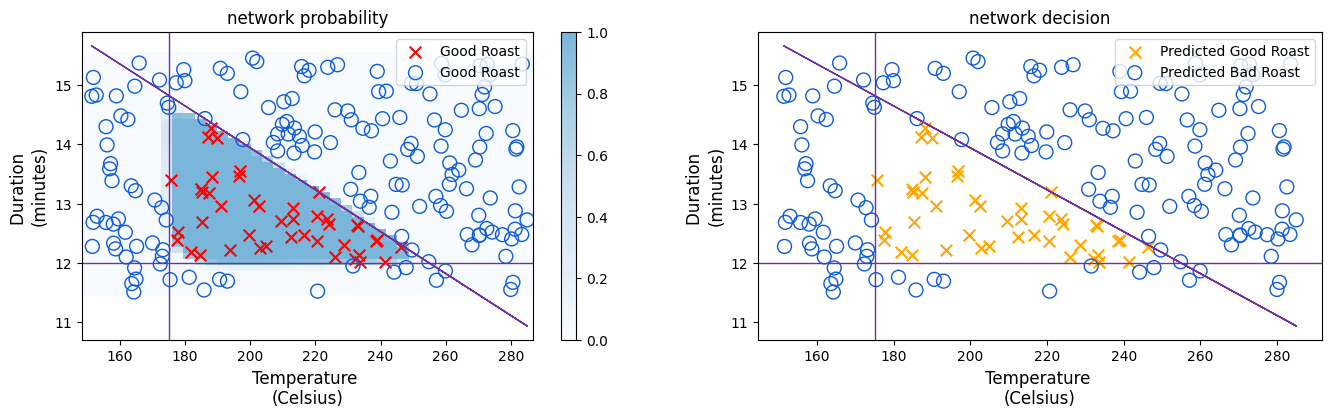

In [19]:
netf = lambda x : my_predict(norm_l(x), W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X, Y, netf)